# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* [Model architecture](Model-Backbone.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* Leverage synthetic training data
    * Fill in the inputs
    * Add visual noise
* [Optimization for production](Optimization.ipynb)


We do not have any real data (clean images derived from pdf-blanks) -- let's generate some noisy filled-in variations.

In [1]:
import pandas as pd
import numpy as np

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from fitz import fitz

In [2]:
# local libs
from scripts.simulate import *

In [3]:
# extracted images
forms = [str(x).split('/').pop()[:-len('.csv.gz')] for x in Path(f'./data/inputs').glob('*.csv.gz')]
len(forms)

7940

### Simulate fill-in
For the better version we would need more fonts. As we target character-level extraction at first -- we input random sequences no need for complex logic.

In [4]:
source = np.random.choice(forms)

In [5]:
print(source)
# load image
image = np.array(ImageOps.grayscale(Image.open(f'./data/images/{source}.png')))

cnd-t2140.en-0


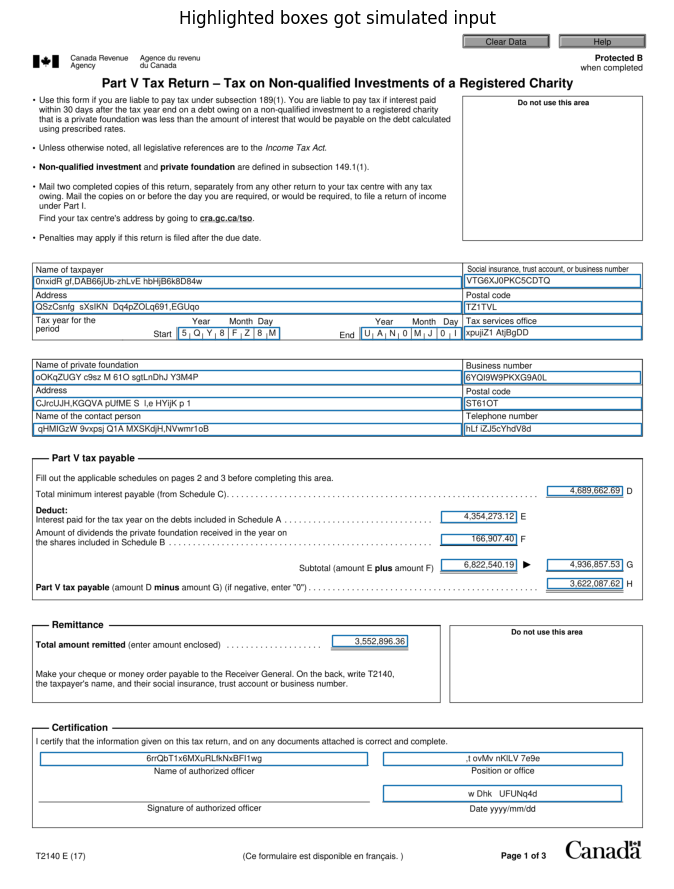

In [6]:
inputs = pd.read_csv(f'./data/inputs/{source}.csv.gz')
# load textual content
content = pd.read_csv(f'./data/content/{source}.csv.gz')[['left','top','right','bottom','text']]
matrix = layout_matrix(content)

index = int(source.split('-').pop())
doc = '-'.join(source.split('-')[:-1])
with fitz.open(f'./data/forms/{doc}.pdf') as doc:
    page = doc.load_page(index)
    image, info = fill_in_blanks(page, 200, matrix)
        
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(image, 'gray')
s = min(image.shape)
for box in inputs[['left','top','right','bottom','field_type_string','field_display']].values:
    x1, y1, x2, y2 = box[:4].astype(float)
    t, d = box[4:]
    w, h = (x2 - x1) * s, (y2 - y1) * s
    x, y = x1 * s, y1 * s
    c = f'C{d}' if t in WIDGETS else 'gray'
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=c, facecolor='none'))
plt.title('Highlighted boxes got simulated input')
plt.axis('off')
plt.show()


In [7]:
pd.DataFrame.from_dict(info)[['field_name','field_display','field_type_string','text_maxlen','value']].head()

,field_name,field_display,field_type_string,text_maxlen,value
0,form1[0].Page1[0].Taxpayer_sub[0].Corp_name[0],0,Text,0,"0nxidR gf,DAB66jUb-zhLvE hbHjB6k8D84w"
1,form1[0].Page1[0].Taxpayer_sub[0].SIN_BN[0],0,Text,15,VTG6XJ0PKC5CDTQ
2,form1[0].Page1[0].Taxpayer_sub[0].Address[0],0,Text,0,"QSzCsnfg sXsIKN Dq4pZOLq691,EGUqo"
3,form1[0].Page1[0].Taxpayer_sub[0].PostalCode_1[0],0,Text,6,TZ1TVL
4,form1[0].Page1[0].Taxpayer_sub[0].FromToDates_...,0,Text,8,5QY8FZ8M


### Simulate noisy data
Let's add some skew (small rotation angle), random orientation (0, 90, 180, 270), uneven light, and noise.

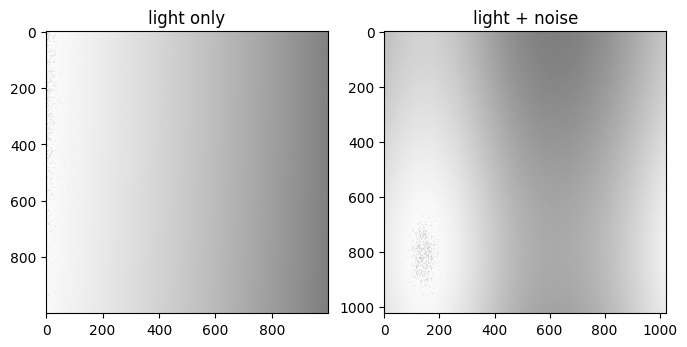

In [8]:
level = 0.5
fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow((generate_noise(1000, scale=2) * 255).astype(np.uint8), 'gray')
ax[0].set_title('light only')
ax[1].imshow((generate_noise(1024, scale=2) * 255).astype(np.uint8), 'gray')
ax[1].set_title('light + noise')
plt.show()

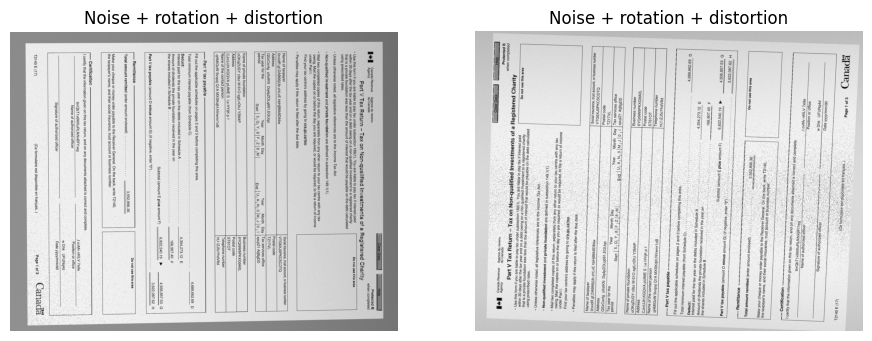

In [9]:
level = 0.5
fig, ax = plt.subplots(1, 2, figsize=(11, 11))
for i in range(2):
    ax[i].imshow(random_transform(image, noise=0.5, perspective=True)[0], 'gray')
    ax[i].set_title('Noise + rotation + distortion')
    ax[i].axis('off')
plt.show()

Takeaway: data-gen for the character-level extraction training is simple, for the form-fields validation we will need some language model.